***Import files and clean***

In [1]:
import os
import zipfile
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
import re

# Define the path to the zip file and the extraction directory
zip_path = r"C:\Users\nxity\Downloads\Songs.zip"
extract_path = r"C:\Users\nxity\Downloads\Songs"

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Read the .abc files from the extracted directory
songs_directory = os.path.join(extract_path, "Songs")
all_songs = []

for filename in os.listdir(songs_directory):
    if filename.endswith(".abc"):
        with open(os.path.join(songs_directory, filename), 'r') as file:
            all_songs.append(file.read())

# At this point, all_songs contains the content of all .abc files
print(all_songs)

["X:1\nT:Alexander's\nZ: id:dc-hornpipe-1\nM:C|\nL:1/8\nK:D Major\n(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe (3dcB A2 (3ABc|!\ndAFA DFAd|fdcd FAdf|gfge fefd|(3efe dc d2:|!\nAG|FAdA FAdA|GBdB GBdB|Acec Acec|dfaf gecA|!\nFAdA FAdA|GBdB GBdB|Aceg fefd|(3efe dc d2:|!", 'X:2\nT:An Buachaill Dreoite\nZ: id:dc-hornpipe-2\nM:C|\nL:1/8\nK:G Major\nGF|DGGB d2GB|d2GF Gc (3AGF|DGGB d2GB|dBcA F2GF|!\nDGGB d2GF|DGGF G2Ge|fgaf gbag|fdcA G2:|!\nGA|B2BG c2cA|d2GF G2GA|B2BG c2cA|d2DE F2GA|!\nB2BG c2cA|d^cde f2 (3def|g2gf gbag|fdcA G2:|!', "X:11\nT:Chief O'Neill's Favourite\nZ: id:dc-hornpipe-10\nM:C|\nL:1/8\nK:D Mixolydian\nde|fefg afge|fde^c d=cAG|FADE FGAB|cAdc A2de|!\nfefg afge|fde^c d=cAG|FADF GBAG|F2D2 D2:|!\nDE|=FEDE FGAB|cAdB cAGc|Adde fded|cAdc A2de|!\nfefg afge|fde^c d=cAG|FADF GBAG|F2D2 D2:|!", 'X:32\nT:Crabs in the Skillet\nZ: id:dc-jig-26\nM:6/8\nL:1/8\nK:G Dorian\nD|G3 d2F|G2A B2c|d_ed cBA|dcB AGF|!\nG3 d2F|G2A B2d|c=Bc fed|cAF F2:|!\nd|gag gfe|fgf fed|cde fed|cAG G2d|!\ngag gfe|fgf fed|cde

# ---------- Section 1: Data Processing ----------

In [2]:
# Remove song titles which appear to be marked by "X:" followed by other metadata till the first note
processed_songs = []

for song in all_songs:
    # Remove everything before the first occurrence of a musical note or symbol
    song = re.sub(r'^.*?([\dA-G^_=(){}\[\]<>|: ])', r'\1', song, flags=re.S)
    processed_songs.append(song)

# Concatenate all songs into a single text for training
training_text = '\n\n'.join(processed_songs)
print(training_text)

:1
T:Alexander's
Z: id:dc-hornpipe-1
M:C|
L:1/8
K:D Major
(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe (3dcB A2 (3ABc|!
dAFA DFAd|fdcd FAdf|gfge fefd|(3efe dc d2:|!
AG|FAdA FAdA|GBdB GBdB|Acec Acec|dfaf gecA|!
FAdA FAdA|GBdB GBdB|Aceg fefd|(3efe dc d2:|!

:2
T:An Buachaill Dreoite
Z: id:dc-hornpipe-2
M:C|
L:1/8
K:G Major
GF|DGGB d2GB|d2GF Gc (3AGF|DGGB d2GB|dBcA F2GF|!
DGGB d2GF|DGGF G2Ge|fgaf gbag|fdcA G2:|!
GA|B2BG c2cA|d2GF G2GA|B2BG c2cA|d2DE F2GA|!
B2BG c2cA|d^cde f2 (3def|g2gf gbag|fdcA G2:|!

:11
T:Chief O'Neill's Favourite
Z: id:dc-hornpipe-10
M:C|
L:1/8
K:D Mixolydian
de|fefg afge|fde^c d=cAG|FADE FGAB|cAdc A2de|!
fefg afge|fde^c d=cAG|FADF GBAG|F2D2 D2:|!
DE|=FEDE FGAB|cAdB cAGc|Adde fded|cAdc A2de|!
fefg afge|fde^c d=cAG|FADF GBAG|F2D2 D2:|!

:32
T:Crabs in the Skillet
Z: id:dc-jig-26
M:6/8
L:1/8
K:G Dorian
D|G3 d2F|G2A B2c|d_ed cBA|dcB AGF|!
G3 d2F|G2A B2d|c=Bc fed|cAF F2:|!
d|gag gfe|fgf fed|cde fed|cAG G2d|!
gag gfe|fgf fed|cde fed|cAF F2:|!
D|G3 A3|B3 c3|d_ed cBA|dcB AGF|!


The regex pattern didn't strip away all the metadata, as the title (T:) and other metadata (Z:, M:, L:, K:) are still present

In [3]:
def process_song(song):
    # Strip metadata
    lines = song.split('\n')
    processed_lines = [line for line in lines if not line.startswith(('X:', 'T:', 'Z:', 'M:', 'L:', 'K:'))]
    
    # Join the lines and then use regex to remove unwanted characters
    joined_lines = '\n'.join(processed_lines)
    
    # Using regex to keep only musical notes and relevant symbols
    clean_song = re.sub(r'[^A-Ga-g0-9|\[\] ]', '', joined_lines)
    
    return clean_song

processed_songs = [process_song(song) for song in all_songs]
training_text = '\n\n'.join(processed_songs)
print(training_text)

3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|3efe 3dcB A2 3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|3efe dc d2|AG|FAdA FAdA|GBdB GBdB|Acec Acec|dfaf gecA|FAdA FAdA|GBdB GBdB|Aceg fefd|3efe dc d2|

GF|DGGB d2GB|d2GF Gc 3AGF|DGGB d2GB|dBcA F2GF|DGGB d2GF|DGGF G2Ge|fgaf gbag|fdcA G2|GA|B2BG c2cA|d2GF G2GA|B2BG c2cA|d2DE F2GA|B2BG c2cA|dcde f2 3def|g2gf gbag|fdcA G2|

de|fefg afge|fdec dcAG|FADE FGAB|cAdc A2de|fefg afge|fdec dcAG|FADF GBAG|F2D2 D2|DE|FEDE FGAB|cAdB cAGc|Adde fded|cAdc A2de|fefg afge|fdec dcAG|FADF GBAG|F2D2 D2|

D|G3 d2F|G2A B2c|ded cBA|dcB AGF|G3 d2F|G2A B2d|cBc fed|cAF F2|d|gag gfe|fgf fed|cde fed|cAG G2d|gag gfe|fgf fed|cde fed|cAF F2|D|G3 A3|B3 c3|ded cBA|dcB AGF|G3 A3|B3 d3|cBc fed|cAF F2|

A|d3 AFD|E2F G2A|BGB Bcd|AGF EFA|d3 AFD|E2F G2A|BGB Bcd|AFD D2|A|d3 cBA|dfe dcB|AFA Bcd|AGF EFA|d3 cBA|dfe dcB|AFA Bcd|AFD D2|g|fef afd|dcd fed|g3 f3|gee efg|fef afd|dcd fed|gfg eag|fdc d2|g|fdf ece|dcB AFd|AFd AFd|AGF E2g|fdf ece|dcB AFA|BGB Bcd|AFD D2|E|F3 GFG|FGF FED|F3 GFG|AFD EFG|F3 GFG|FGF FE

The provided output seem to contain only the musical notes and related symbols, with metadata (such as song titles and other musical notations) stripped away.

I believe I have removed all the funnies and left only music notes, lack of domain expertise makes this a bit tricky

# ---------- Section 2: Dataset Definition ----------

In [ ]:
class ABCNotationDataset(Dataset):
    def __init__(self, text, seq_length=100):
        self.text = text
        self.vocab = sorted(set(text))
        self.vocab_to_int = {c: i for i, c in enumerate(self.vocab)}
        self.int_to_vocab = {i: c for c, i in self.vocab_to_int.items()}
        self.seq_length = seq_length
    
    def __len__(self):
        return len(self.text) - self.seq_length
    
    def __getitem__(self, index):
        sequence = self.text[index: index + self.seq_length]
        label = self.text[index + 1: index + self.seq_length + 1]
        
        sequence_tensor = torch.tensor([self.vocab_to_int[char] for char in sequence], dtype=torch.long)
        label_tensor = torch.tensor([self.vocab_to_int[char] for char in label], dtype=torch.long)
        
        return sequence_tensor, label_tensor

dataset = ABCNotationDataset(training_text)

# Example encoded song and label as a tensor.
dataset = ABCNotationDataset(training_text)
sequence, label = dataset[0]
print(sequence)
print(label)

# ---------- Section 3: Model Definition ----------

In [5]:
class ABCNotationModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers):
        super(ABCNotationModel, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.rnn(x)
        x = self.fc(output)
        return x

model = ABCNotationModel(len(dataset.vocab), 64, 128, 2)

# ---------- Section 4: Data Splitting ----------

In [6]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# ---------- Section 5: Training Setup ----------

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# ---------- Section 6: Training Function ----------

In [8]:
def train(model, train_dataset, val_dataset, criterion, optimizer, epochs, batch_size, patience=5):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    train_losses = []
    val_losses = []
    
    best_val_loss = float('inf')
    no_improvement_count = 0
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for sequences, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs.transpose(1, 2), labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        train_losses.append(epoch_loss / len(train_loader))
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for sequences, labels in val_loader:
                outputs = model(sequences)
                loss = criterion(outputs.transpose(1, 2), labels)
                val_loss += loss.item()
        
        val_losses.append(val_loss / len(val_loader))
        
        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improvement_count = 0
        else:
            no_improvement_count += 1
            if no_improvement_count >= patience:
                print("Early stopping due to no improvement in validation loss.")
                break

    return train_losses, val_losses

# ---------- Section 7: Train the Model ----------

In [9]:
# Can adjust the epochs and batch_size as needed
train_losses, val_losses = train(model, train_dataset, val_dataset, criterion, optimizer, epochs=10, batch_size=128)

Epoch 1/10, Train Loss: 1.3827, Val Loss: 1.1336
Epoch 2/10, Train Loss: 1.0331, Val Loss: 0.9573
Epoch 3/10, Train Loss: 0.8927, Val Loss: 0.8453
Epoch 4/10, Train Loss: 0.7990, Val Loss: 0.7694
Epoch 5/10, Train Loss: 0.7374, Val Loss: 0.7194
Epoch 6/10, Train Loss: 0.6968, Val Loss: 0.6900
Epoch 7/10, Train Loss: 0.6708, Val Loss: 0.6683
Epoch 8/10, Train Loss: 0.6523, Val Loss: 0.6537
Epoch 9/10, Train Loss: 0.6393, Val Loss: 0.6444
Epoch 10/10, Train Loss: 0.6299, Val Loss: 0.6349


***Loss Curve***

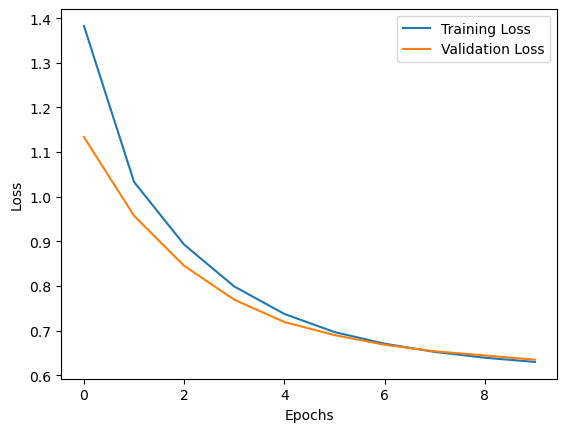

In [10]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

***Final Evaluation***

In [11]:
def generate_song(model, dataset, initial_string, length):
    model.eval()
    generated = initial_string
    sequence = torch.tensor([dataset.vocab_to_int[char] for char in initial_string], dtype=torch.long).unsqueeze(0)
    for _ in range(length):
        output = model(sequence)
        next_char = dataset.int_to_vocab[int(torch.argmax(output[0, -1]))]
        generated += next_char
        sequence = torch.cat([sequence, torch.tensor([[dataset.vocab_to_int[next_char]]], dtype=torch.long)], 1)
    return generated

final_song = generate_song(model, dataset, "ABC", 200)
print(final_song)

ABC|DGG2 AGFD|E2cE dEcE|D2BD AGFD|E2cE dEcE|AGEF G2|]

E|DGGF G3F|DEFG AFDF|G2BG DGBA|GBB2 gBB2|g2bg efdf|a2fd efge|afge dcBA|GABc d2Bd|edef g2B|BcBA BGBd|c2AB cBAG|A2AB A3A|GABc d2|

D|EGBG AGED|E2GE DE


***Results interpretation***                                                                                                  

The sequence generated seems to be coherent in terms of the structure and patterns typically found in musical notations I believe, I also listened to the MP3, sounds good. Due to lack of domain expertise I am unable to say how good the song is. The presence of musical patterns does suggest that the model has learned some underlying structures from the training data. These patterns indicate that the model is not producing random characters, but rather sequences that have some musical significance based on its training. 

In [19]:
abc_header = """
X:1
T:Generated Song
M:4/4
L:1/8
K:C
"""

complete_song = abc_header + final_song

In [20]:
#pip install music21

In [21]:
from music21 import converter, midi

# Parse the ABC notation to create a music21 stream
s = converter.parse(complete_song, format="abc")

# Save the stream as a MIDI file
mf = midi.translate.music21ObjectToMidiFile(s)
mf.open('generated_song.mid', 'wb')
mf.write()
mf.close()

In [22]:
import os

# Convert MIDI to WAV using FluidSynth
os.system("fluidsynth -ni soundfont.sf2 generated_song.mid -F generated_song.wav -r 44100")

# Convert WAV to MP3 using FFmpeg
os.system("ffmpeg -i generated_song.wav generated_song.mp3")

1